# 彼得與狼：真實環境

在我們的情境中，彼得幾乎可以四處走動而不會感到疲倦或飢餓。在更真實的世界中，他需要時不時坐下休息，並且還需要進食。讓我們通過實現以下規則，使我們的世界更加真實：

1. 每次從一個地方移動到另一個地方，彼得會失去**能量**並增加一些**疲勞**。
2. 彼得可以通過吃蘋果來獲得更多能量。
3. 彼得可以通過在樹下或草地上休息來消除疲勞（即走到有樹或草的棋盤位置——綠色區域）。
4. 彼得需要找到並殺死狼。
5. 為了殺死狼，彼得需要擁有一定的能量和疲勞水平，否則他會輸掉戰鬥。


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

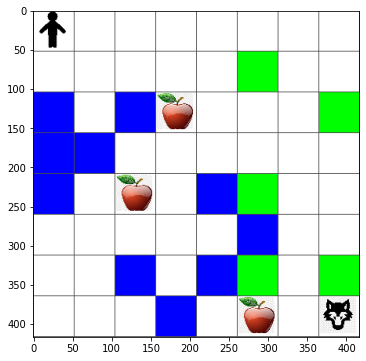

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## 定義狀態

在我們的新遊戲規則中，我們需要追蹤每個棋盤狀態下的能量和疲勞。因此，我們將創建一個物件 `state`，用來保存所有有關當前問題狀態的必要資訊，包括棋盤的狀態、當前的能量和疲勞水平，以及在終端狀態下是否能擊敗狼：


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

讓我們嘗試使用隨機遊走來解決問題，看看是否成功：


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## 獎勵函數

### 簡介
獎勵函數是強化學習中非常重要的一部分。它指導代理如何在環境中行動以達到目標。

[!NOTE] 獎勵函數的設計直接影響代理的行為。

### 設計原則
以下是設計獎勵函數時需要考慮的一些原則：

1. **清晰明確**: 獎勵函數應該簡單易懂，避免過於複雜。
2. **鼓勵正確行為**: 獎勵應該促使代理採取期望的行動。
3. **避免意外行為**: 獎勵函數設計不當可能導致代理採取不符合目標的行為。
4. **平衡短期與長期目標**: 獎勵應該既能激勵短期行動，也能支持長期目標。

[!WARNING] 不良的獎勵設計可能導致代理學習到錯誤的行為。

### 示例
以下是一個簡單的獎勵函數示例：

```python
def reward_function(state, action):
    if action == "desired_action":
        return 1  # 獎勵
    else:
        return -1  # 懲罰
```

[!TIP] 獎勵函數可以根據具體需求進行調整。

### 常見問題
#### 如何測試獎勵函數？
可以通過模擬代理的行為來測試獎勵函數，觀察代理是否能達到預期目標。

#### 獎勵函數是否需要頻繁更新？
通常情況下，獎勵函數設計完成後不需要頻繁更新，但如果代理的行為不符合預期，可能需要進行調整。

[!IMPORTANT] 獎勵函數的設計是一個迭代過程，需要不斷嘗試和改進。

### 結論
設計一個有效的獎勵函數是強化學習成功的關鍵。遵循上述原則並進行充分測試，可以幫助代理更好地完成任務。


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learning 演算法

實際的學習演算法基本上保持不變，我們只是使用 `state` 而不是僅僅使用棋盤位置。


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

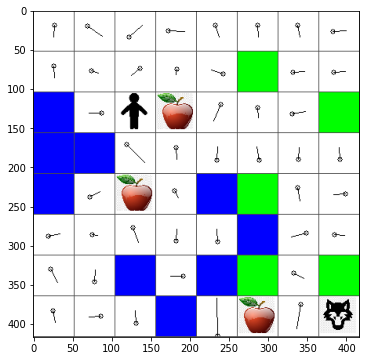

In [11]:
m.plot(Q)

## 結果

讓我們看看我們是否成功訓練彼得對抗狼！


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


我們現在看到溺水的案例少了很多，但彼得仍然無法總是殺死狼。嘗試進行實驗，看看是否可以通過調整超參數來改善這個結果。


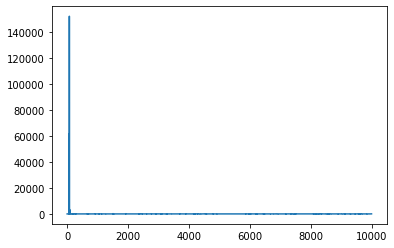

In [13]:
plt.plot(lpath)


---

**免責聲明**：  
本文件已使用人工智能翻譯服務 [Co-op Translator](https://github.com/Azure/co-op-translator) 進行翻譯。儘管我們致力於提供準確的翻譯，但請注意，自動翻譯可能包含錯誤或不準確之處。原始語言的文件應被視為權威來源。對於重要資訊，建議使用專業人工翻譯。我們對因使用此翻譯而引起的任何誤解或錯誤解釋概不負責。
